In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import xarray as xr
import pandas as pd
from xgcm import Grid
import numpy as np
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
import os
from datetime import timedelta

In [20]:
import bsose.preprocess as pp

In [21]:
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4_3D, ErrorCode

### Define FieldSet

In [31]:
rootdir = "/local/data/bSOSE/iter133NEW/5day/"
filenames = {'U':rootdir+'bsose_i133_2013to2018_5day_Uvel.nc',
             'V':rootdir+'bsose_i133_2013to2018_5day_Vvel.nc',
             'W':rootdir+'bsose_i133_2013to2018_5day_Wvel.nc',
             'T':rootdir+'bsose_i133_2013to2018_5day_Theta.nc',
             'S':rootdir+'bsose_i133_2013to2018_5day_Salt.nc'}
variables = {'U': 'UVEL',
             'V': 'VVEL',
             'W': 'WVEL',
             'T': 'THETA',
             'S': 'SALT'}
dimensions = {'U':{'lon':'XG','lat':'YC','depth':'Z','time':'time'},
             'V':{'lon':'XC','lat':'YG','depth':'Z','time':'time'},
             'W':{'lon':'XC','lat':'YC','depth':'Zl','time':'time'},
             'T':{'lon':'XC','lat':'YC','depth':'Z','time':'time'},
             'S':{'lon':'XC','lat':'YC','depth':'Z','time':'time'}}
fs = FieldSet.from_netcdf(filenames,variables,dimensions,
                          deferred_load=True,gridindexingtype='mitgcm')

In [ ]:
# Pick up T and S
class TSParticle(JITParticle):
    T = Variable('T', dtype=np.float32)
    S = Variable('S', dtype=np.float32)

def SampleTS(particle, fieldset, time):
    particle.T = fieldset.T[time,
                            particle.depth,
                            particle.lat,
                            particle.lon]
    particle.S = fieldset.S[time,
                            particle.depth,
                            particle.lat,
                            particle.lon]

In [32]:
N = 50
lats1D = np.linspace(-61.5,-55.5,N)
lons1D=291*np.ones(N)
depths1D=-1*np.linspace(1000,3000,N)
[lons,lats,depths] = np.meshgrid(lons1D,lats1D,depths1D)
times=fs.U.grid.time[-1]
pset = ParticleSet(fieldset=fs, pclass=TSParticle,
                  lon=lons,lat=lats,depth=depths,time=times)  

### Run and save particles

In [33]:
fileout = "output"+".time_back-last.init_Drake.length_4yr"+".nc"
if os.path.isfile(fileout):
    os.remove(fileout)
output_file = pset.ParticleFile(name=fileout, outputdt=timedelta(days=10))

kernel = AdvectionRK4_3D

pset.execute(kernel,
             runtime=timedelta(days=4*365),
             dt=-timedelta(minutes=360),
             output_file=output_file)
output_file.export()

INFO: Compiled ArrayJITParticleAdvectionRK4_3D ==> /tmp/parcels-995200043/lib51265a86bb1f94e0279f70bd9bb600e7_0.so
INFO: Temporary output files are stored in out-MNVRIZSC.
INFO: You can use "parcels_convert_npydir_to_netcdf out-MNVRIZSC" to convert these to a NetCDF file during the run.
100% (126144000.0 of 126144000.0) |######| Elapsed Time: 0:42:25 Time:  0:42:25


In [34]:
try:
    output.close()
    print('output closed')
except:
    pass
output = xr.open_dataset('output.nc', cache=False, decode_times=False)

output closed


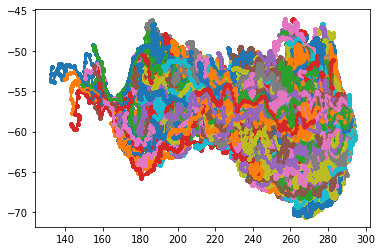

In [35]:
plt.plot(output['lon'].transpose(),output['lat'].transpose(),'.-');

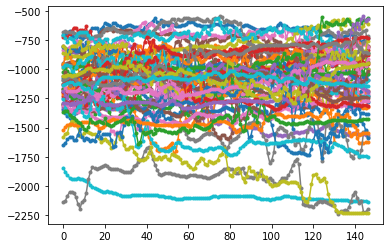

In [26]:
fig,ax = plt.subplots()
ax.plot(output['z'].transpose(),'.-');

In [30]:
times

188784000.0